   SalesRevenue ProductSubcategory  ProductSubcategoryID  ProductCategoryID  \
0    11861.9652         Road Bikes                     2                  1   
1    12634.4688         Road Bikes                     2                  1   
2     7907.9768         Road Bikes                     2                  1   
3     3953.9884         Road Bikes                     2                  1   
4    15815.9536         Road Bikes                     2                  1   

   SalesYear    DueDate  
0       2011 2011-06-28  
1       2011 2011-10-29  
2       2011 2011-09-13  
3       2011 2011-10-06  
4       2011 2011-12-08  


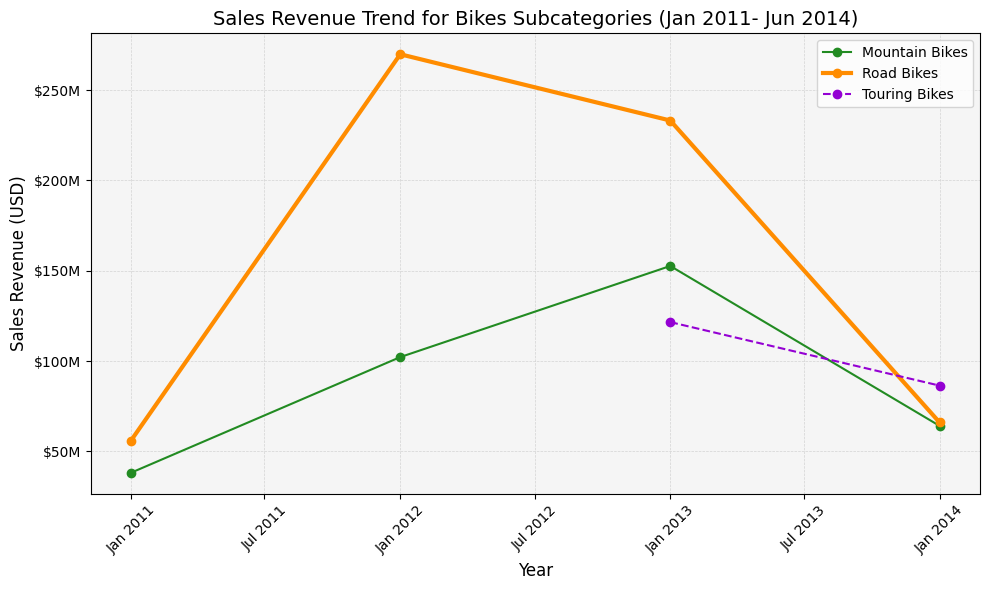

In [12]:
from sqlalchemy import create_engine
import pandas as pd

# Create the SQLAlchemy engine using the pyodbc driver
connection_string = "mssql+pyodbc://DESKTOP-19LPOE8\\SQLEXPRESS/AdventureWorks2022?driver=ODBC+Driver+17+for+SQL+Server"
engine = create_engine(connection_string)

# 2. Define the SQL query to fetch data for sales revenue and quantity
query = """
SELECT SUM(soh.TotalDue) as SalesRevenue,
	   ps.Name as ProductSubcategory,
	   p.ProductSubcategoryID,
	   pc.ProductCategoryID,
	   YEAR(soh.DueDate) as SalesYear,
	   soh.DueDate
FROM AdventureWorks2022.Sales.SalesOrderHeader soh
LEFT JOIN AdventureWorks2022.Sales.SalesOrderDetail sod
    ON soh.SalesOrderID = sod.SalesOrderID
LEFT JOIN Production.Product p
    ON p.ProductID = sod.ProductID
LEFT JOIN Production.ProductSubcategory ps
    ON ps.ProductSubcategoryID = p.ProductSubcategoryID
LEFT JOIN Production.ProductCategory pc
    ON ps.ProductCategoryID = pc.ProductCategoryID
WHERE pc.ProductCategoryID = 1
GROUP BY
    YEAR(soh.DueDate),
	ps.Name,
	p.ProductSubcategoryID,
	soh.DueDate,
	pc.ProductCategoryID
ORDER BY SalesYear;
"""

# Load data into pandas DataFrame
df = pd.read_sql(query, engine)

# Display the first few rows of the data
print(df.head())

# Close the connection
engine.dispose()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

# Filter data for each subcategory
df_mountain_bikes = df[df['ProductSubcategory'] == 'Mountain Bikes']
df_road_bikes = df[df['ProductSubcategory'] == 'Road Bikes']
df_touring_bikes = df[df['ProductSubcategory'] == 'Touring Bikes']

# Aggregate sales revenue by year for each subcategory
df_mountain_bikes_yearly = df_mountain_bikes.groupby('SalesYear').agg({'SalesRevenue': 'sum'}).reset_index()
df_road_bikes_yearly = df_road_bikes.groupby('SalesYear').agg({'SalesRevenue': 'sum'}).reset_index()
df_touring_bikes_yearly = df_touring_bikes.groupby('SalesYear').agg({'SalesRevenue': 'sum'}).reset_index()

# Convert 'SalesYear' to datetime
df_mountain_bikes_yearly['SalesYear'] = pd.to_datetime(df_mountain_bikes_yearly['SalesYear'], format='%Y')
df_road_bikes_yearly['SalesYear'] = pd.to_datetime(df_road_bikes_yearly['SalesYear'], format='%Y')
df_touring_bikes_yearly['SalesYear'] = pd.to_datetime(df_touring_bikes_yearly['SalesYear'], format='%Y')

# Scale sales revenue to millions for better readability
df_mountain_bikes_yearly['SalesRevenue'] /= 1e6  # Convert to millions
df_road_bikes_yearly['SalesRevenue'] /= 1e6
df_touring_bikes_yearly['SalesRevenue'] /= 1e6


# Plot the line chart
plt.figure(figsize=(10, 6))

# Plot the line chart for Mountain Bikes
plt.plot(df_mountain_bikes_yearly['SalesYear'], df_mountain_bikes_yearly['SalesRevenue'], marker='o', color='forestgreen', label='Mountain Bikes')

# Plot the line chart for Road Bikes
plt.plot(df_road_bikes_yearly['SalesYear'], df_road_bikes_yearly['SalesRevenue'], marker='o', color='darkorange', label='Road Bikes', linewidth='3')

# Plot the line chart for Touring Bikes
plt.plot(df_touring_bikes_yearly['SalesYear'], df_touring_bikes_yearly['SalesRevenue'], marker='o', color='darkviolet', label='Touring Bikes', linestyle="--")

# Add labels and title
plt.title('Sales Revenue Trend for Bikes Subcategories (Jan 2011- Jun 2014)', fontsize=14, color='black')
plt.xlabel('Year', fontsize=12, color='black')
plt.ylabel('Sales Revenue (USD)', fontsize=12, color='black')

# Format x-axis labels as 'Jan 2011'
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=6))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Format y-axis to show dollar sign
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: "${:,.0f}M".format(int(x))))

# Customize plot appearance
plt.gca().set_facecolor('whitesmoke')
plt.gcf().set_facecolor('white')

# Change tick colors to white
plt.xticks(color='black')
plt.yticks(color='black')

# Add gridlines for better readability
plt.grid(True, color='lightgray', linestyle='--', linewidth=0.5)

# Add legend to differentiate between the subcategories
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()